In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data/Potato",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
potato_class_names = dataset.class_names

In [10]:
potato_class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
68*32

2176

In [13]:
for img,label in dataset.take(1):
    print(img.shape)
    print(label.numpy())

(32, 256, 256, 3)
[0 2 1 0 0 0 0 1 1 0 1 0 2 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1]


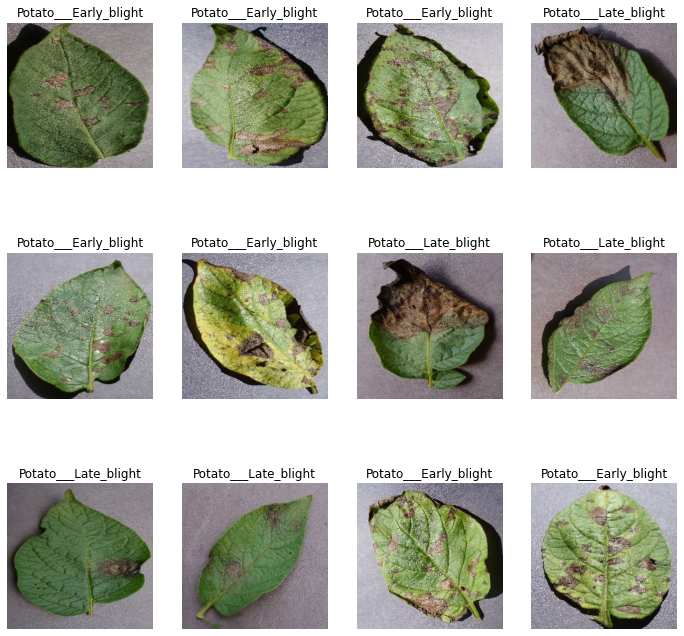

In [14]:
plt.figure(figsize=(12,12))
for img,label in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(potato_class_names[label[i]])
        plt.axis("off")

In [15]:
# 80% --> training data
# 20% --> 10% validation, 10% test

In [16]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [17]:
train_ds = dataset.take(54)
len(train_ds)

54

In [18]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [19]:
val_sz = 0.1
len(dataset)*val_sz

6.800000000000001

In [20]:
#Validation dataset
val_ds = test_ds.take(6)
print(len(val_ds))

#Test dataset
test_ds = test_ds.skip(6)
print(len(test_ds))

6
8


In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    ds_size = len(ds)
    
    train_size = int(ds_size * train_split)
    val_size   = int(ds_size * val_split) 
    
    train_ds   = dataset.take(train_size)
    test_ds    = dataset.skip(train_size)
    val_ds     = test_ds.take(val_size)
    test_ds    = test_ds.skip(val_size)
    
    return train_ds,val_ds,test_ds

In [22]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [29]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 56s 1s/step - loss: 0.8967 - accuracy: 0.4977 - val_loss: 0.7698 - val_accuracy: 0.5990
Epoch 2/30
54/54 [==============================] - 54s 1s/step - loss: 0.5994 - accuracy: 0.7251 - val_loss: 0.4526 - val_accuracy: 0.8333
Epoch 3/30
54/54 [==============================] - 54s 997ms/step - loss: 0.3704 - accuracy: 0.8565 - val_loss: 0.2865 - val_accuracy: 0.8906
Epoch 4/30
54/54 [==============================] - 55s 1s/step - loss: 0.2903 - accuracy: 0.8883 - val_loss: 0.3058 - val_accuracy: 0.8750
Epoch 5/30
54/54 [==============================] - 54s 1s/step - loss: 0.2288 - accuracy: 0.9074 - val_loss: 0.2025 - val_accuracy: 0.9219
Epoch 6/30
54/54 [==============================] - 55s 1s/step - loss: 0.2328 - accuracy: 0.9057 - val_loss: 0.2507 - val_accuracy: 0.9375
Epoch 7/30
54/54 [==============================] - 55s 1s/step - loss: 0.1949 - accuracy: 0.9230 - val_loss: 0.1273 - val_accuracy: 0.9531
Epoch 8/30
54/54 

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 421ms/step - loss: 0.1419 - accuracy: 0.9612


In [32]:
scores

[0.14186599850654602, 0.9612069129943848]

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
len(history.history['accuracy'])

30

In [37]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

Text(0.5, 1.0, 'Loss over each epochs')

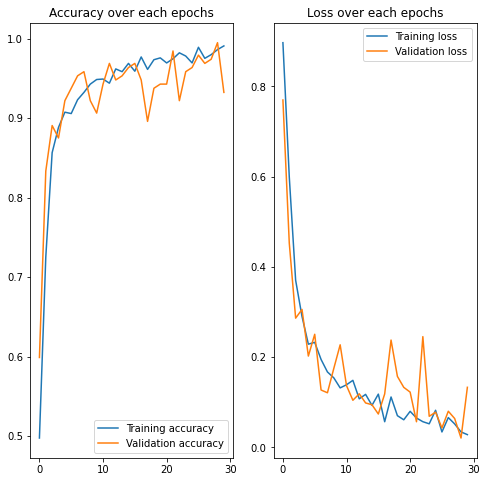

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation accuracy')
plt.legend()
plt.title('Accuracy over each epochs')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Loss over each epochs')

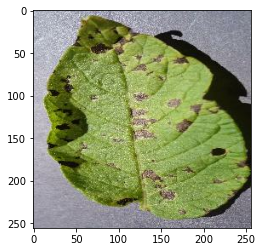

In [39]:
for img,label in test_ds.take(1):
    
    plt.imshow(img[0].numpy().astype('uint8'))

first image to predict
actual label:  Potato___Early_blight
Predicted label:  Potato___Early_blight


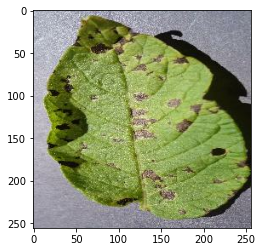

In [40]:
import numpy as np
for img,label in test_ds.take(1):
    
    first_img = img[0].numpy().astype('uint8')
    first_label = label[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_img)
    print('actual label: ', potato_class_names[first_label])
    
    batch_prediction = model.predict(img)
    print('Predicted label: ', potato_class_names[np.argmax(batch_prediction[0])])

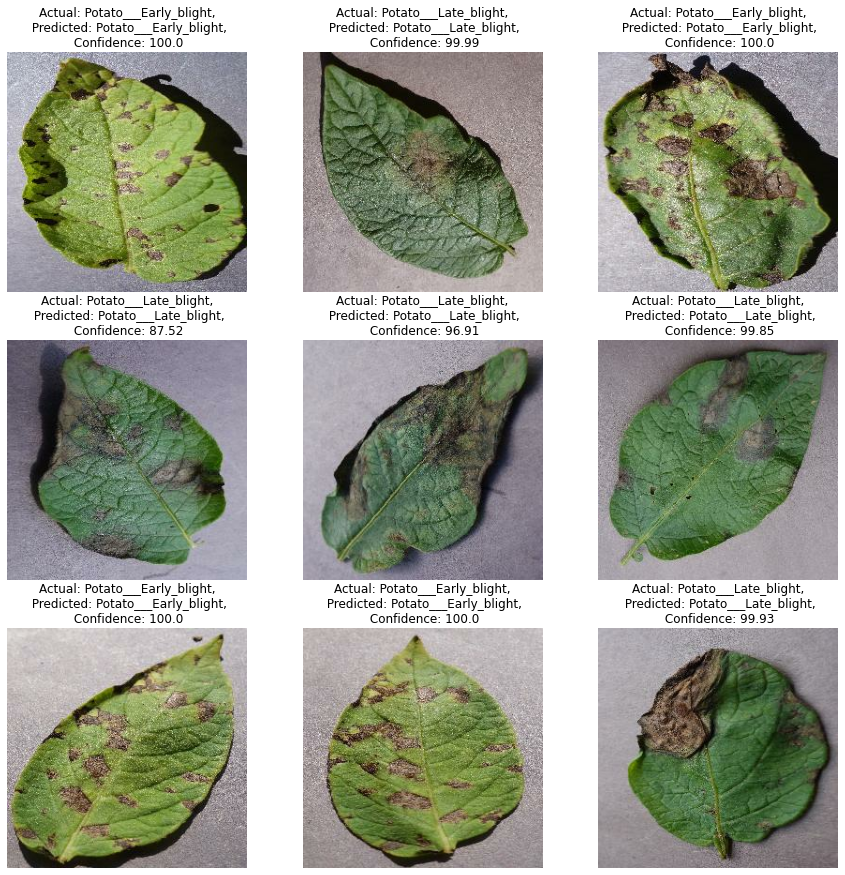

In [41]:
plt.figure(figsize=(15,15))
for img,label in test_ds.take(1):
    
    batch_prediction = model.predict(img)
    
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.axis('off')
        
        confidence = round(100*np.max(batch_prediction[i]), 2)
        predicted_class = potato_class_names[np.argmax(batch_prediction[i])]
        
        plt.title(f'''Actual: {potato_class_names[label[i]]},\n Predicted: {predicted_class},\n Confidence: {confidence}''')

In [46]:
import os
model_version = max([int(i) for i in os.listdir('Models/Potato/') + [0]])+1
model_version

1

In [47]:
model.save(f"Models/Potato/{model_version}")

INFO:tensorflow:Assets written to: Models/Potato/1\assets


In [49]:
model.save("../potatoes.h5")